# Import Statements

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 

# Correlation Matrix example 

In [3]:
processed_data_directory = './data_by_league'

# files = os.listdir(processed_data_directory)

file_path  = os.path.join(processed_data_directory, 'LCK.csv')


In [4]:
df = pd.read_csv(file_path)
df

,team,gold_diff,gold_diff_14min,elder_dragon_kills,baron_kills,dragon_kills,herald_kills,team_KD_ratio,game_length,objectives_stolen_away,first_turret_kill,second_turret_kill,third_turret_kill,baron_powerplay,first_blood,result
0,KT,11528,1812,0,2,2,1,2.090909,35.987300,0,1037306.0,1948408.0,2115845.0,965.0,False,1
1,LSB,-11528,-1812,0,0,3,1,0.478261,35.987300,0,1036206.0,NaN,NaN,0.0,True,0
2,KT,12007,2545,0,1,3,0,4.250000,24.753417,0,931593.0,1359309.0,1451427.0,3608.0,True,1
3,T1,-12007,-2545,0,0,0,2,0.235294,24.753417,0,1251860.0,NaN,NaN,0.0,False,0
4,DRX,7624,278,0,2,2,2,1.600000,33.767400,0,1006762.0,1753906.0,1995268.0,698.0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,DRX,-13779,-265,0,0,0,1,0.142857,29.366433,0,1314063.0,NaN,NaN,0.0,False,0
494,HLE,4426,-962,0,1,2,0,4.500000,32.320933,0,1672912.0,1776652.0,1903868.0,4077.0,True,1
495,KDF,-4426,962,0,0,2,2,0.222222,32.320933,0,1014505.0,NaN,NaN,0.0,False,0
496,HLE,4416,22,0,2,2,1,2.000000,44.130517,0,1009437.0,2530562.0,2620661.0,558.0,False,1


In [5]:
from scipy.stats import chi2_contingency
df['result']
df['first_blood']

contingency_table = pd.crosstab(df['result'], df['first_blood'])

# Perform the chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")


Chi-Square Statistic: 39.3574297188755
P-Value: 3.5290750474075914e-10


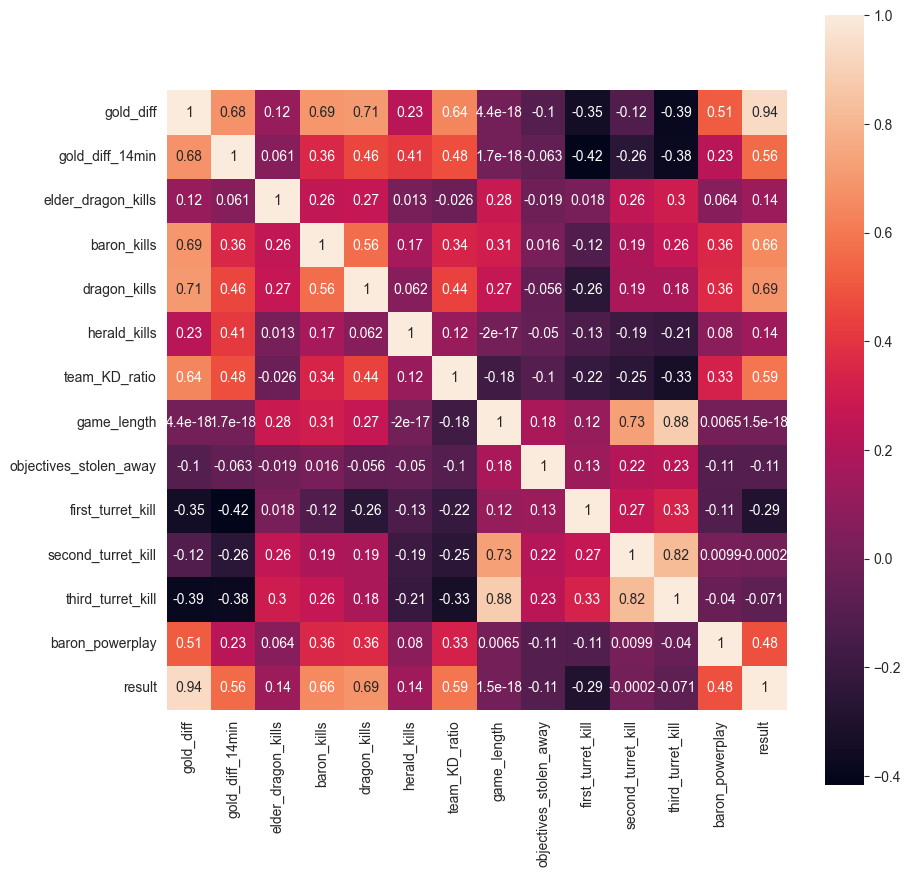

In [6]:
fig = plt.figure(figsize=(10,10))
a = sns.heatmap(df[['gold_diff', 'gold_diff_14min', 'elder_dragon_kills','baron_kills', 'dragon_kills', 'herald_kills', 'team_KD_ratio', 'game_length', 'objectives_stolen_away','first_turret_kill', 'second_turret_kill', 'third_turret_kill', 'baron_powerplay', 'result']].corr(),annot=True,square=True)


# Creating the retrieval model   

In [7]:
import tensorflow as tf 
import tensorflow_recommenders as tfrs 
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
import pprint

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Split the dataset into training and testing dataset with an 80/20 split 

In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


# Extract the unique teams and attributes of the game 

In [197]:
class RFCModel():
    
    def __init__(self, league):
        self.clf = None 
        self.model_accuracy = None 
        self.league = league
        self.teams = {}
        self.df = None 
        self.df_no_teams = None 
        
    def calculate_rankings(self):
        
        teams = self.df['team'].unique()
        for team in teams:
            # team_all_matches = pd.DataFrame(columns=self.df_no_teams.columns)
            # team_all_matches.columns = team_all_matches.columns.astype(str) 
            wins, losses = 0, 0
            
            for index, row in self.df.iterrows():
                if row['team'] == team:
                    new_row = (self.df_no_teams.iloc[index].drop(labels=['result']).values.reshape(1,-1))
                    predictions = self.clf.predict(new_row)
                    if predictions:
                        wins += 1 
                    else:
                        losses += 1 
            print(wins / (wins + losses) * 100)
                
                    
            # print(team_all_matches)
                    
                    
        
        
        
    def create_model(self):
        processed_data_directory = './data_by_league'
        file_name = self.league + ".csv"
        file_path  = os.path.join(processed_data_directory, file_name)
        self.df = pd.read_csv(file_path)
        self.df.dropna(inplace=True, ignore_index=True)
        self.df_no_teams = self.df.drop(columns=['team', 'elder_dragon_kills', 'game_length', 'second_turret_kill', 'third_turret_kill', 'first_blood'], axis=1)
        
        x = self.df_no_teams.drop(columns=['result'])
        y = self.df_no_teams['result']
        
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        # print(f"training data: {X_train}")
        
        # Create a Random Forest Classifier
        self.clf = RandomForestClassifier(random_state=42)
        
        # Train the model
        self.clf.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = self.clf.predict(X_test)
        
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        
        self.model_accuracy = accuracy

        

In [199]:
lck = RFCModel("PCS")
lck.create_model()
lck.calculate_rankings()

/Users/yslee/Desktop/LoLHackathon/venv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/yslee/Desktop/LoLHackathon/venv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/yslee/Desktop/LoLHackathon/venv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/yslee/Desktop/LoLHackathon/venv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/yslee/Desktop/LoLHackathon/venv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomFore

86.95652173913044
100.0
75.0
96.0
100.0
78.94736842105263
95.65217391304348
88.23529411764706
100.0
100.0
100.0
100.0
50.0


/Users/yslee/Desktop/LoLHackathon/venv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/yslee/Desktop/LoLHackathon/venv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/yslee/Desktop/LoLHackathon/venv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/yslee/Desktop/LoLHackathon/venv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/yslee/Desktop/LoLHackathon/venv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomFore

In [200]:
s1 = pd.DataFrame(['1', '2'])
for index, data in s1.iterrows():
    print(index)
    

0
1


In [95]:
s1

,0
0,1
1,2


In [96]:
s2

0    3
1    4
dtype: object

In [97]:
s3

,0
0,1
1,2
0,3
1,4
